43it [01:58,  2.76s/it]00:03,  3.22s/it]


<IPython.core.display.Javascript object>


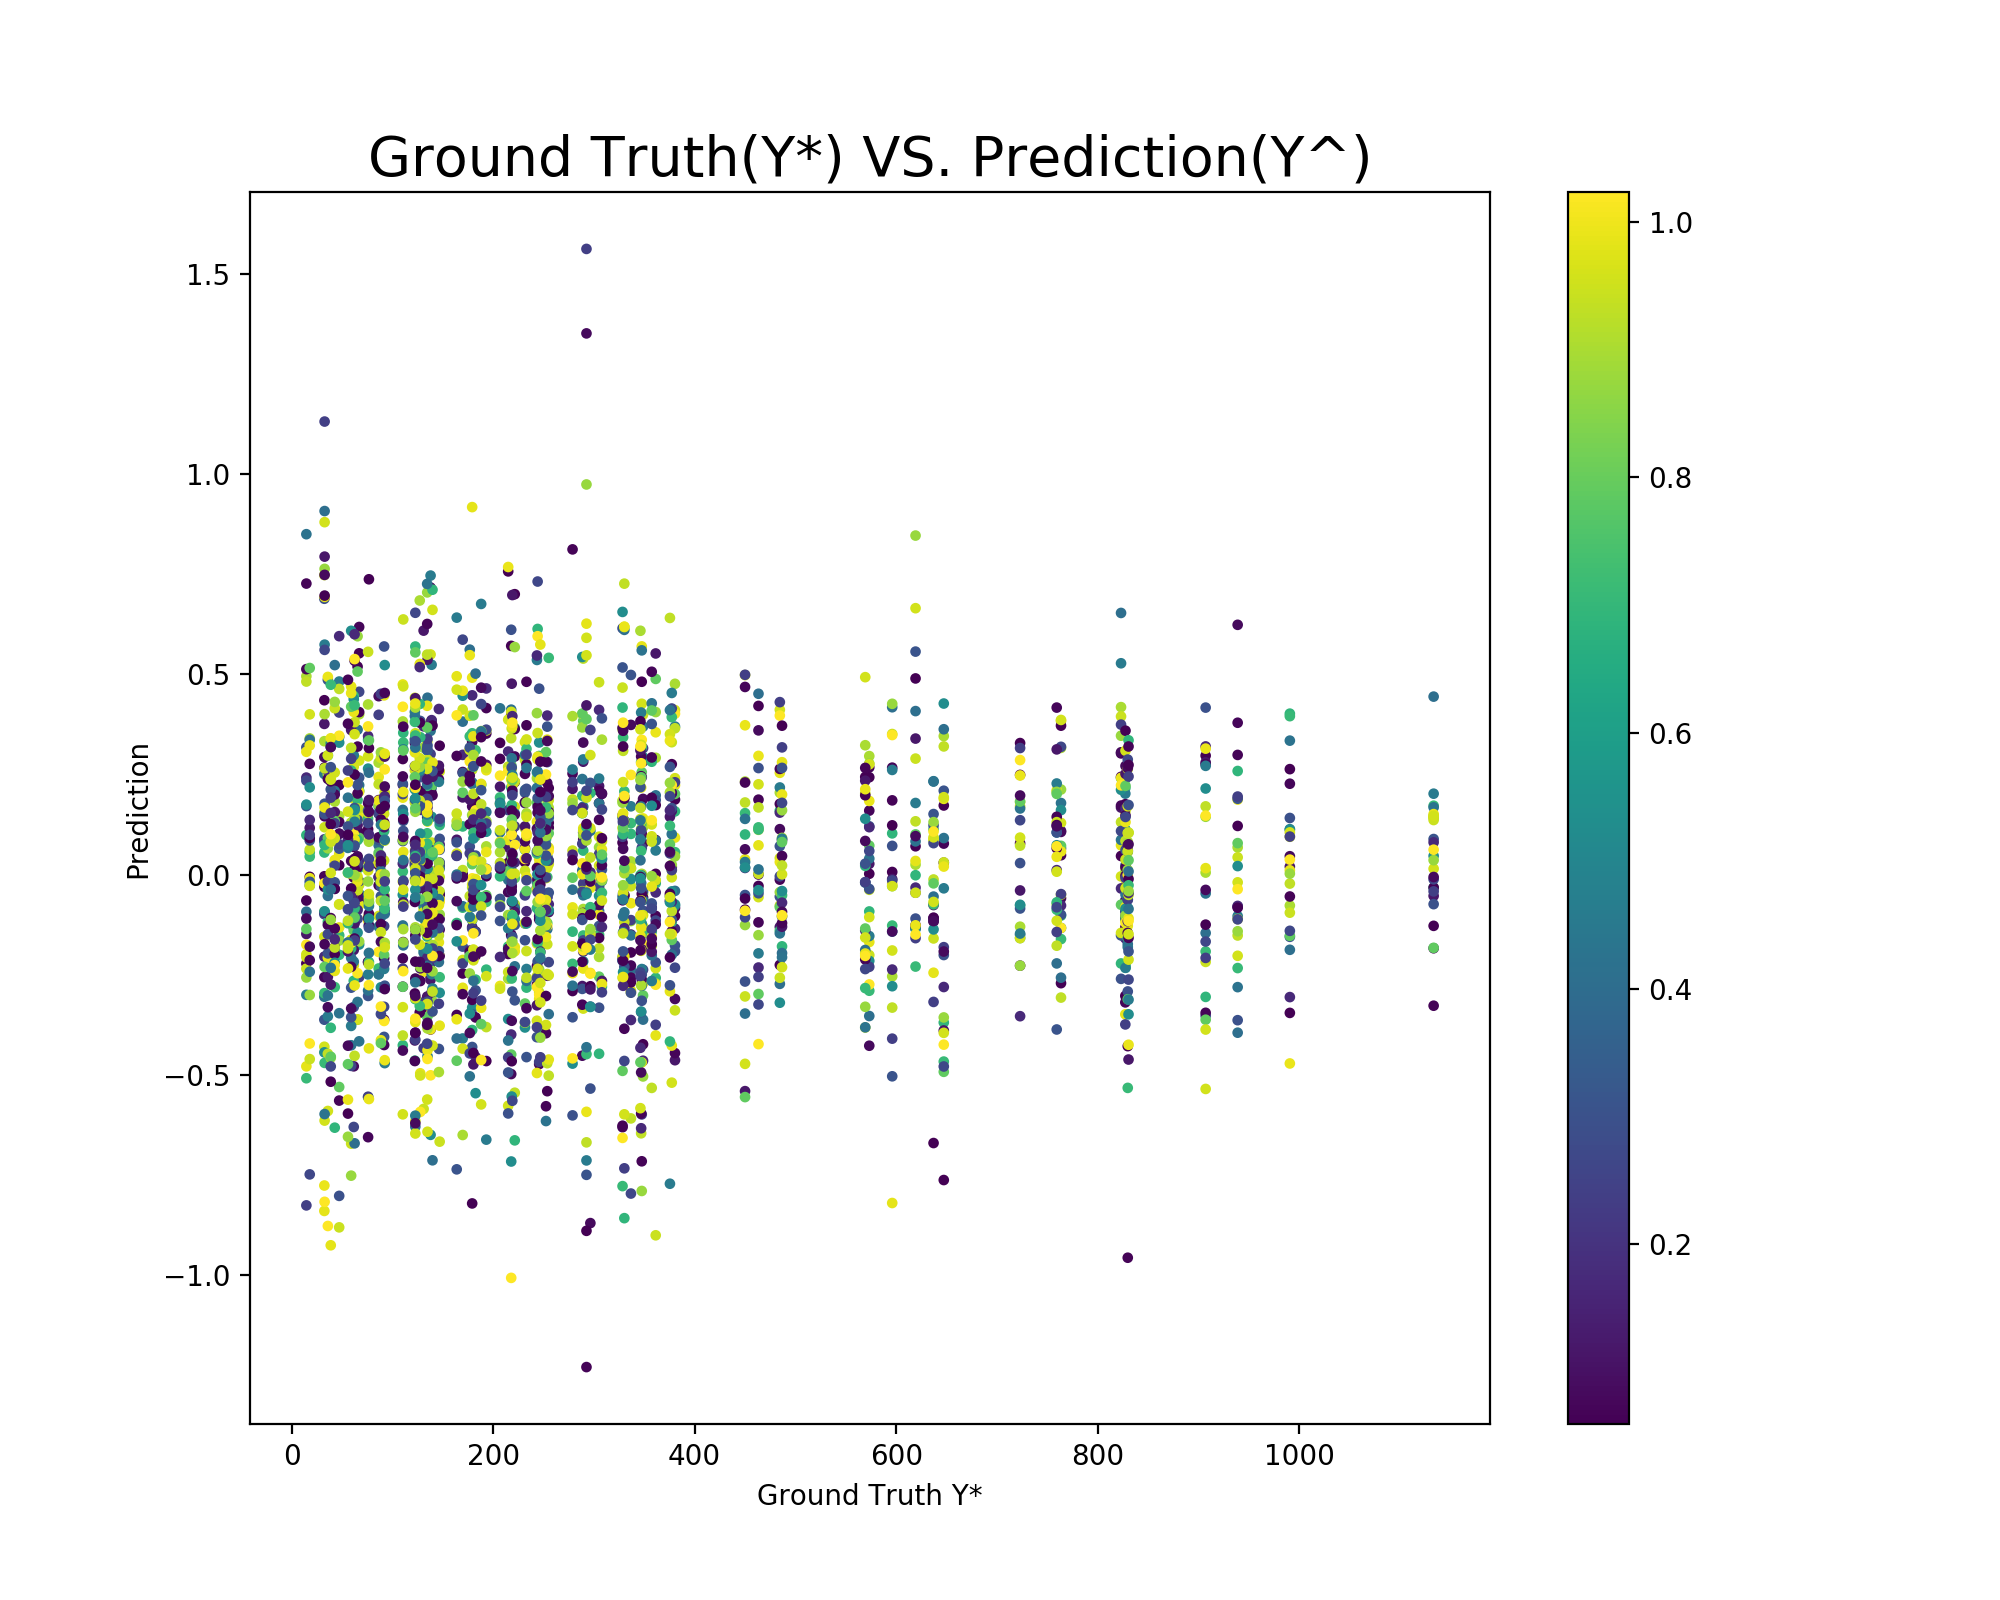

<IPython.core.display.Javascript object>


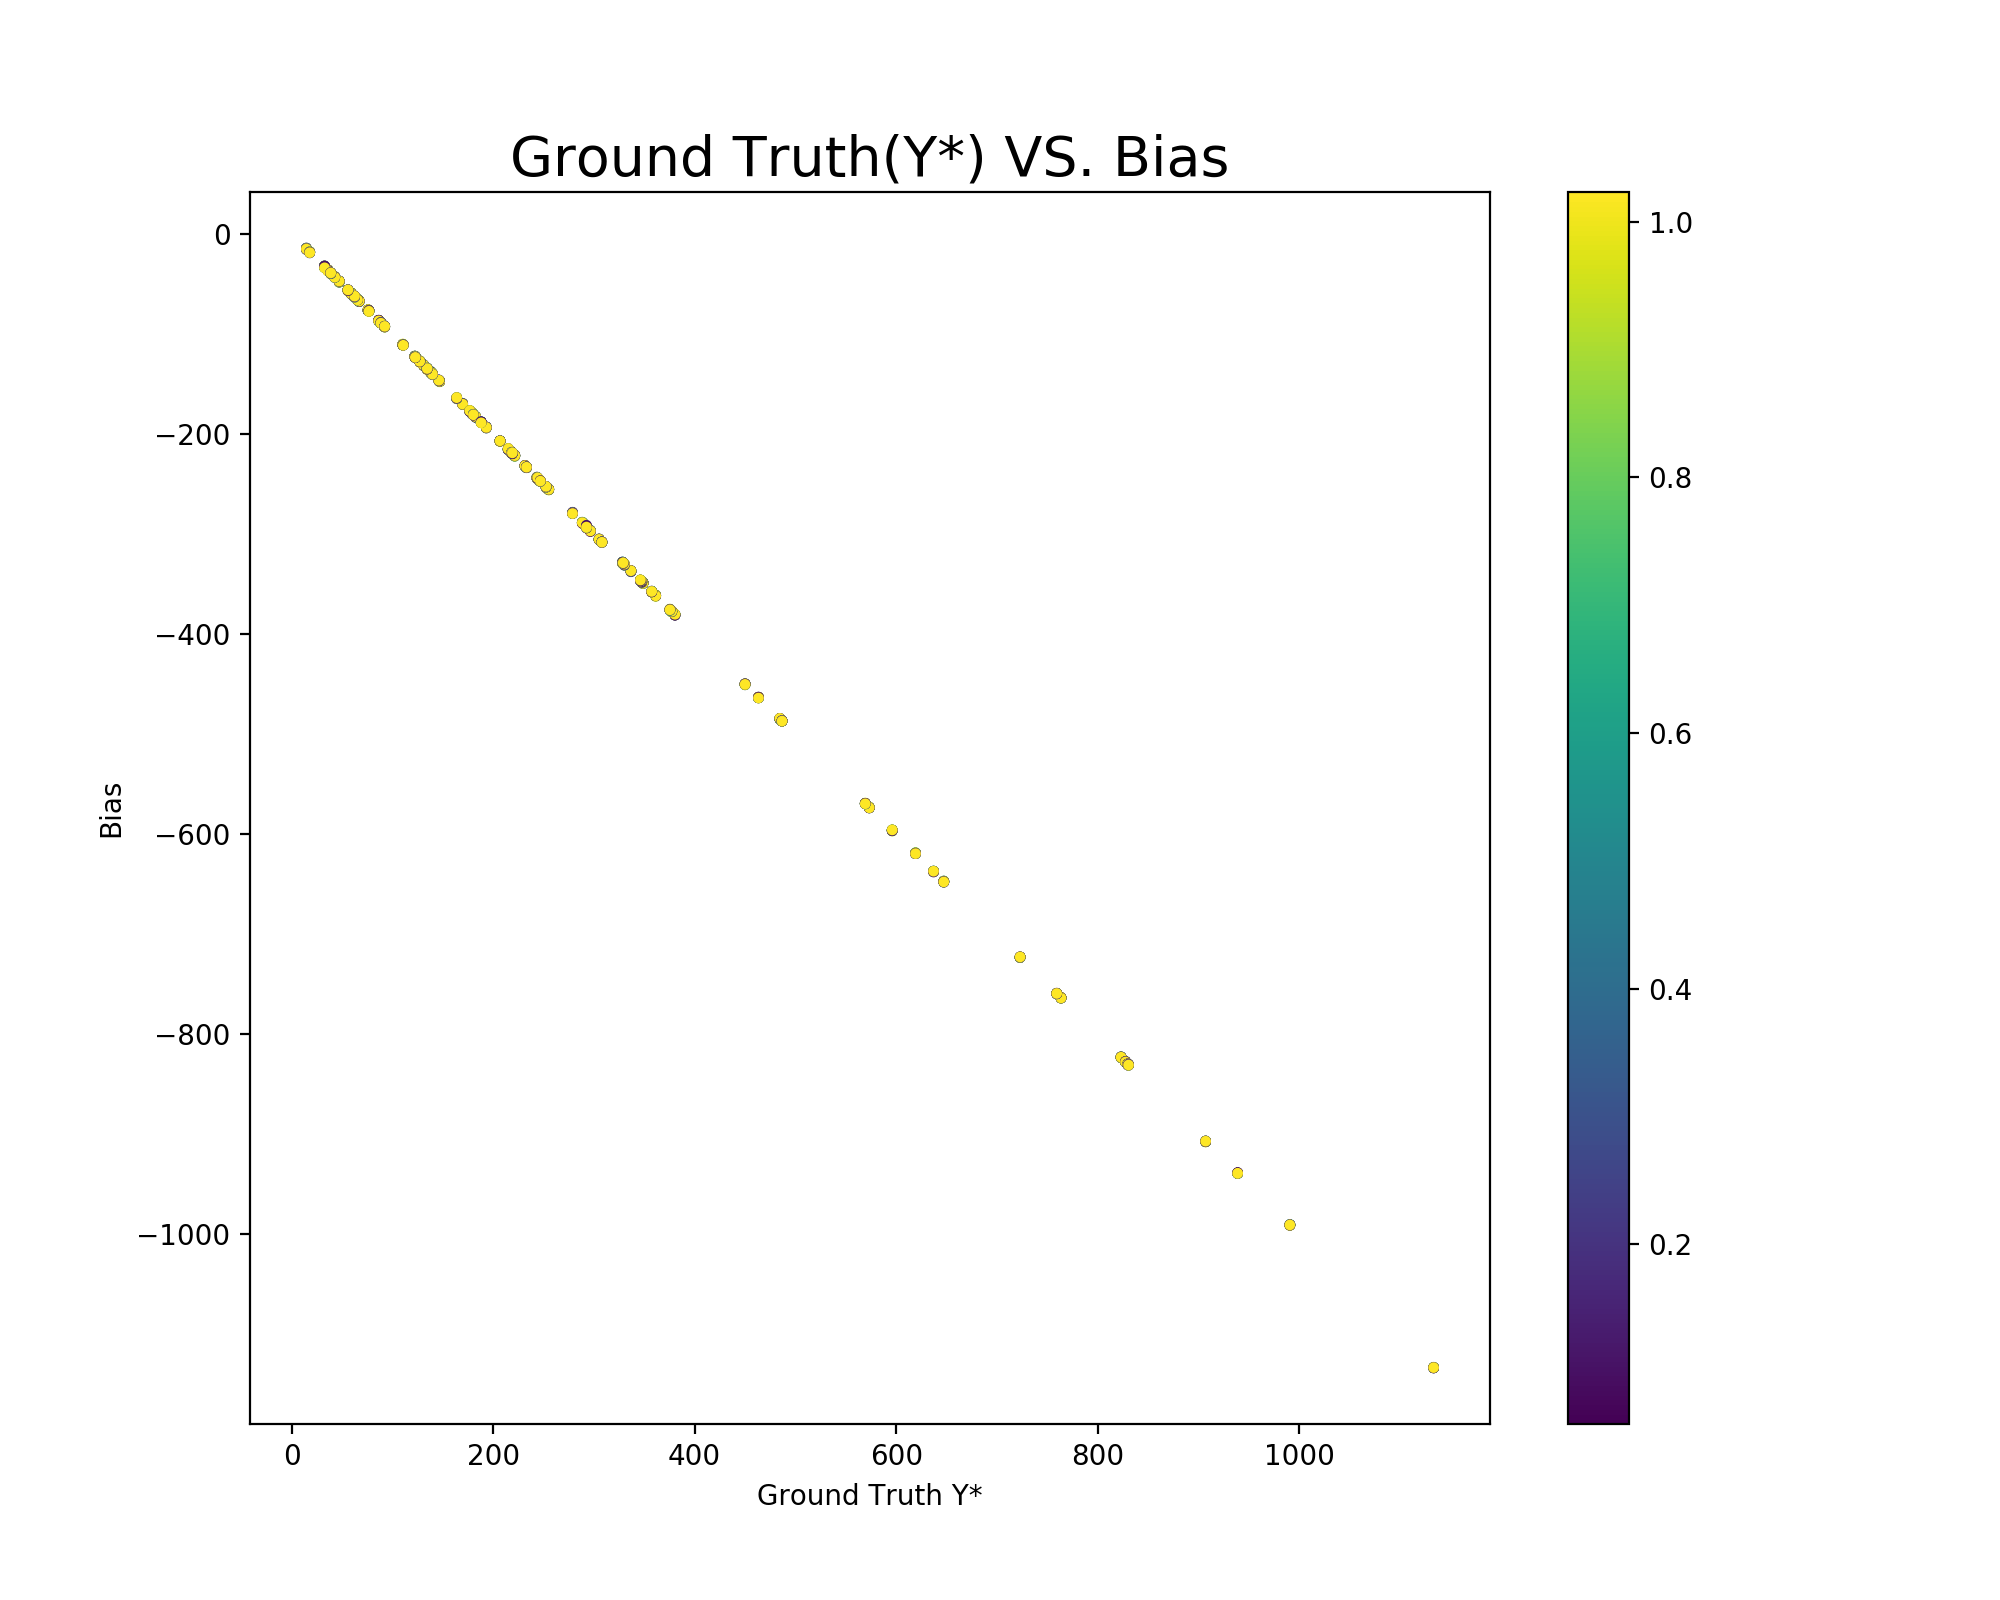

<IPython.core.display.Javascript object>


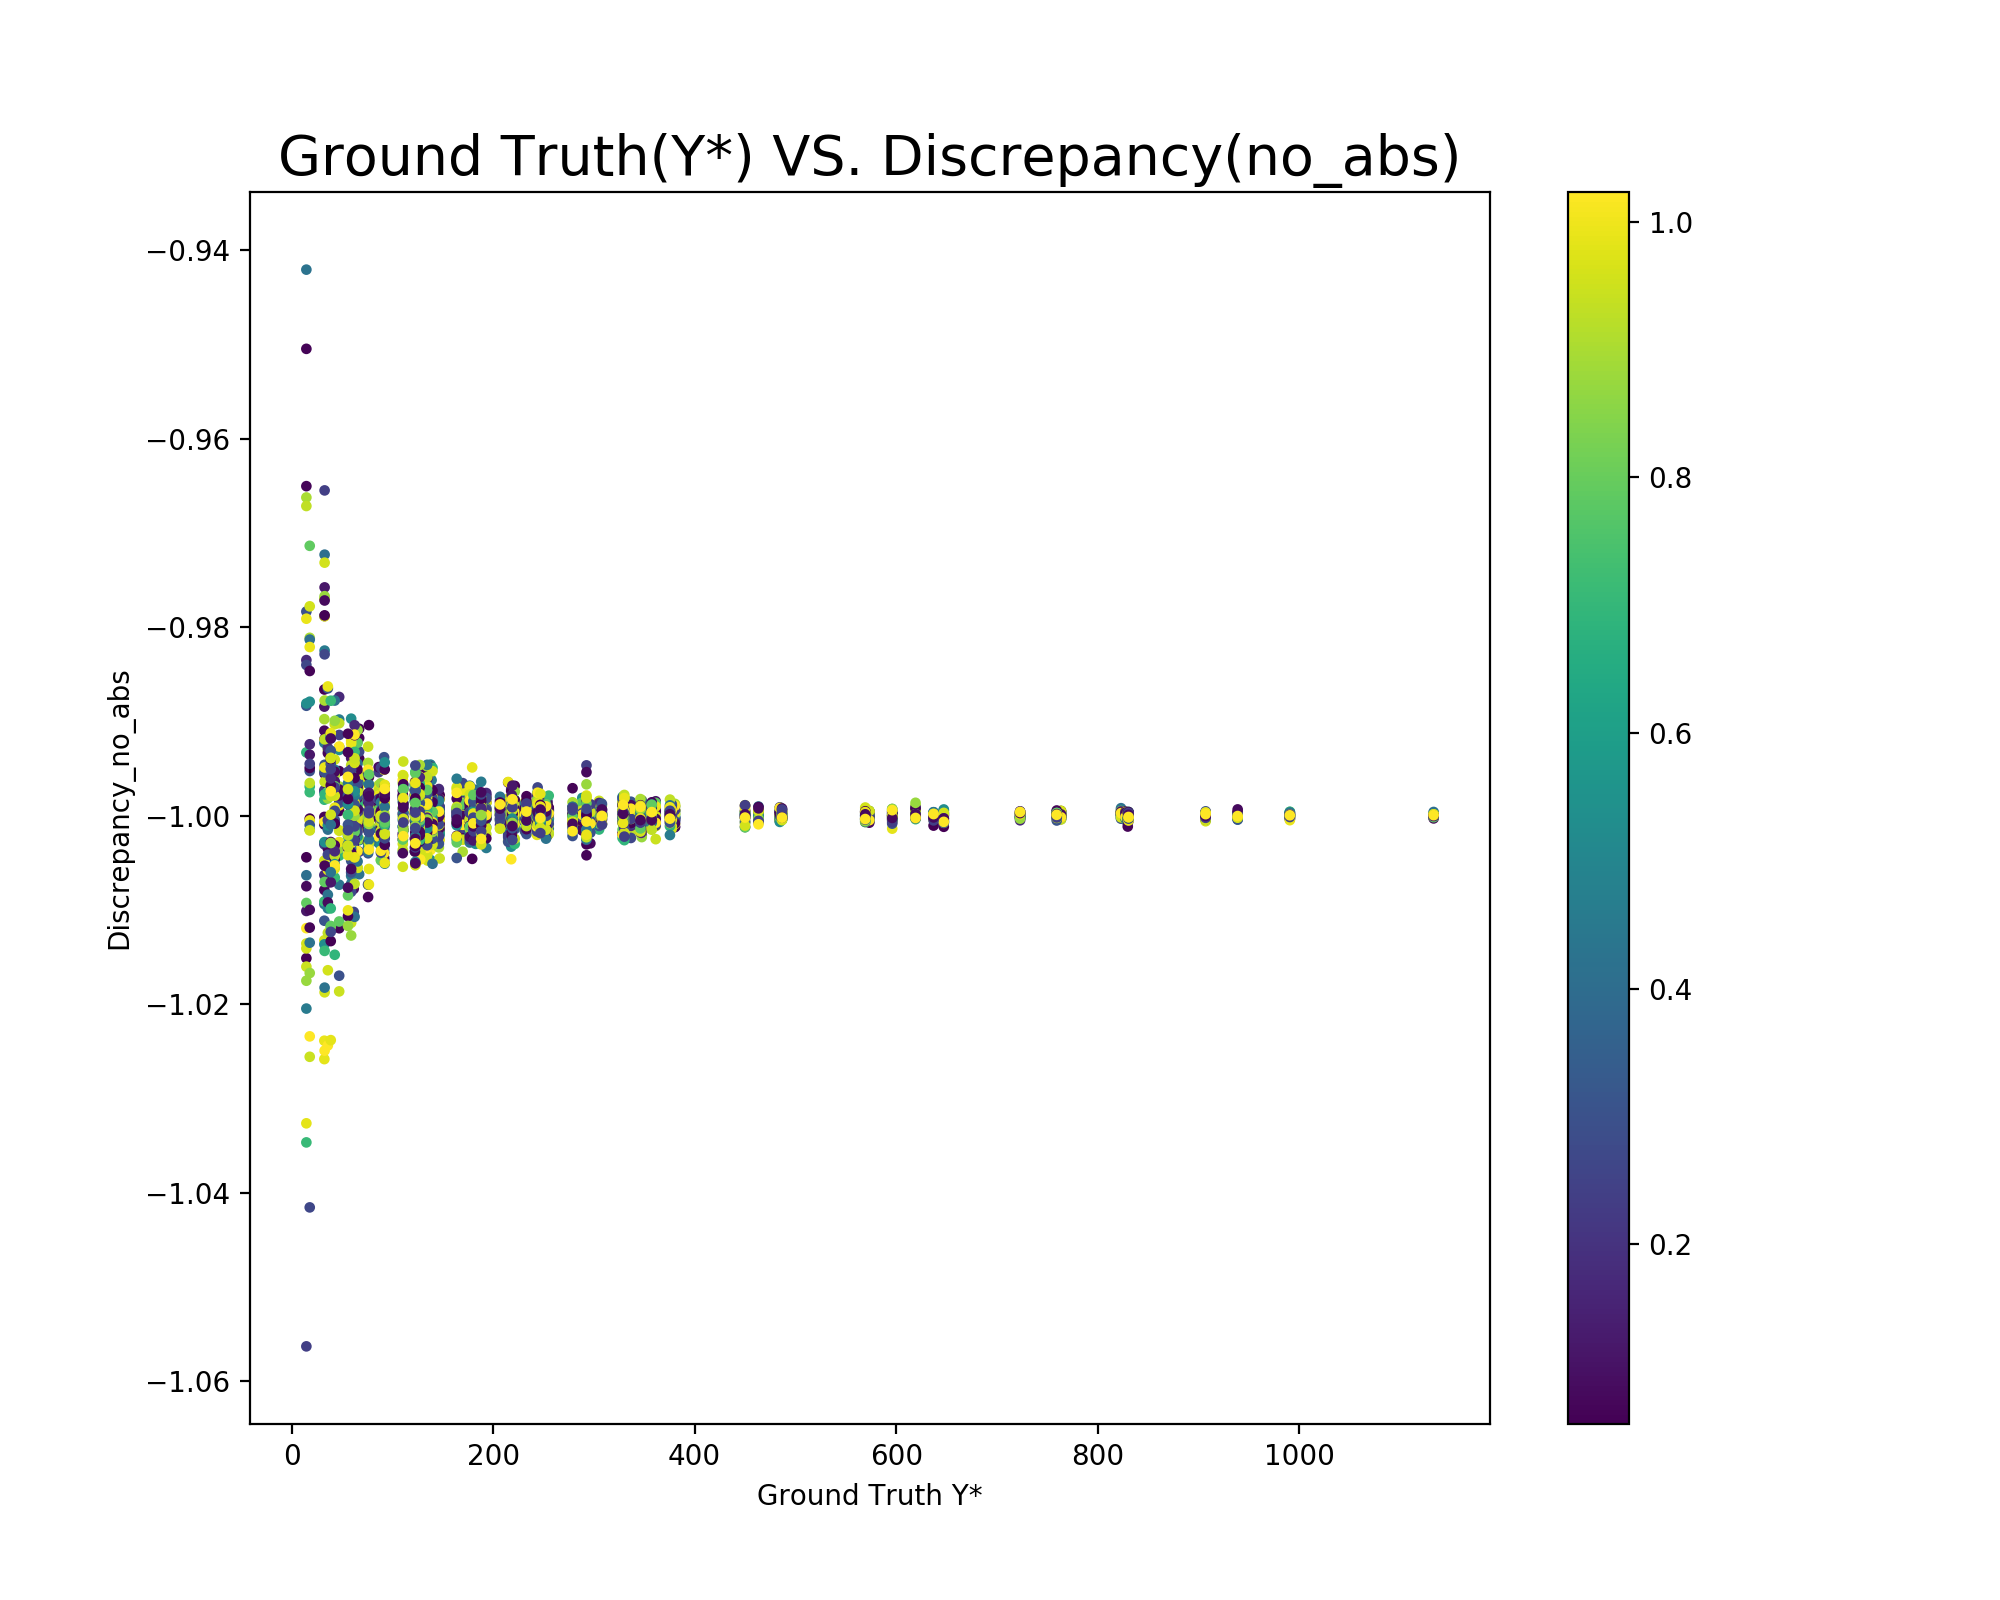

<IPython.core.display.Javascript object>


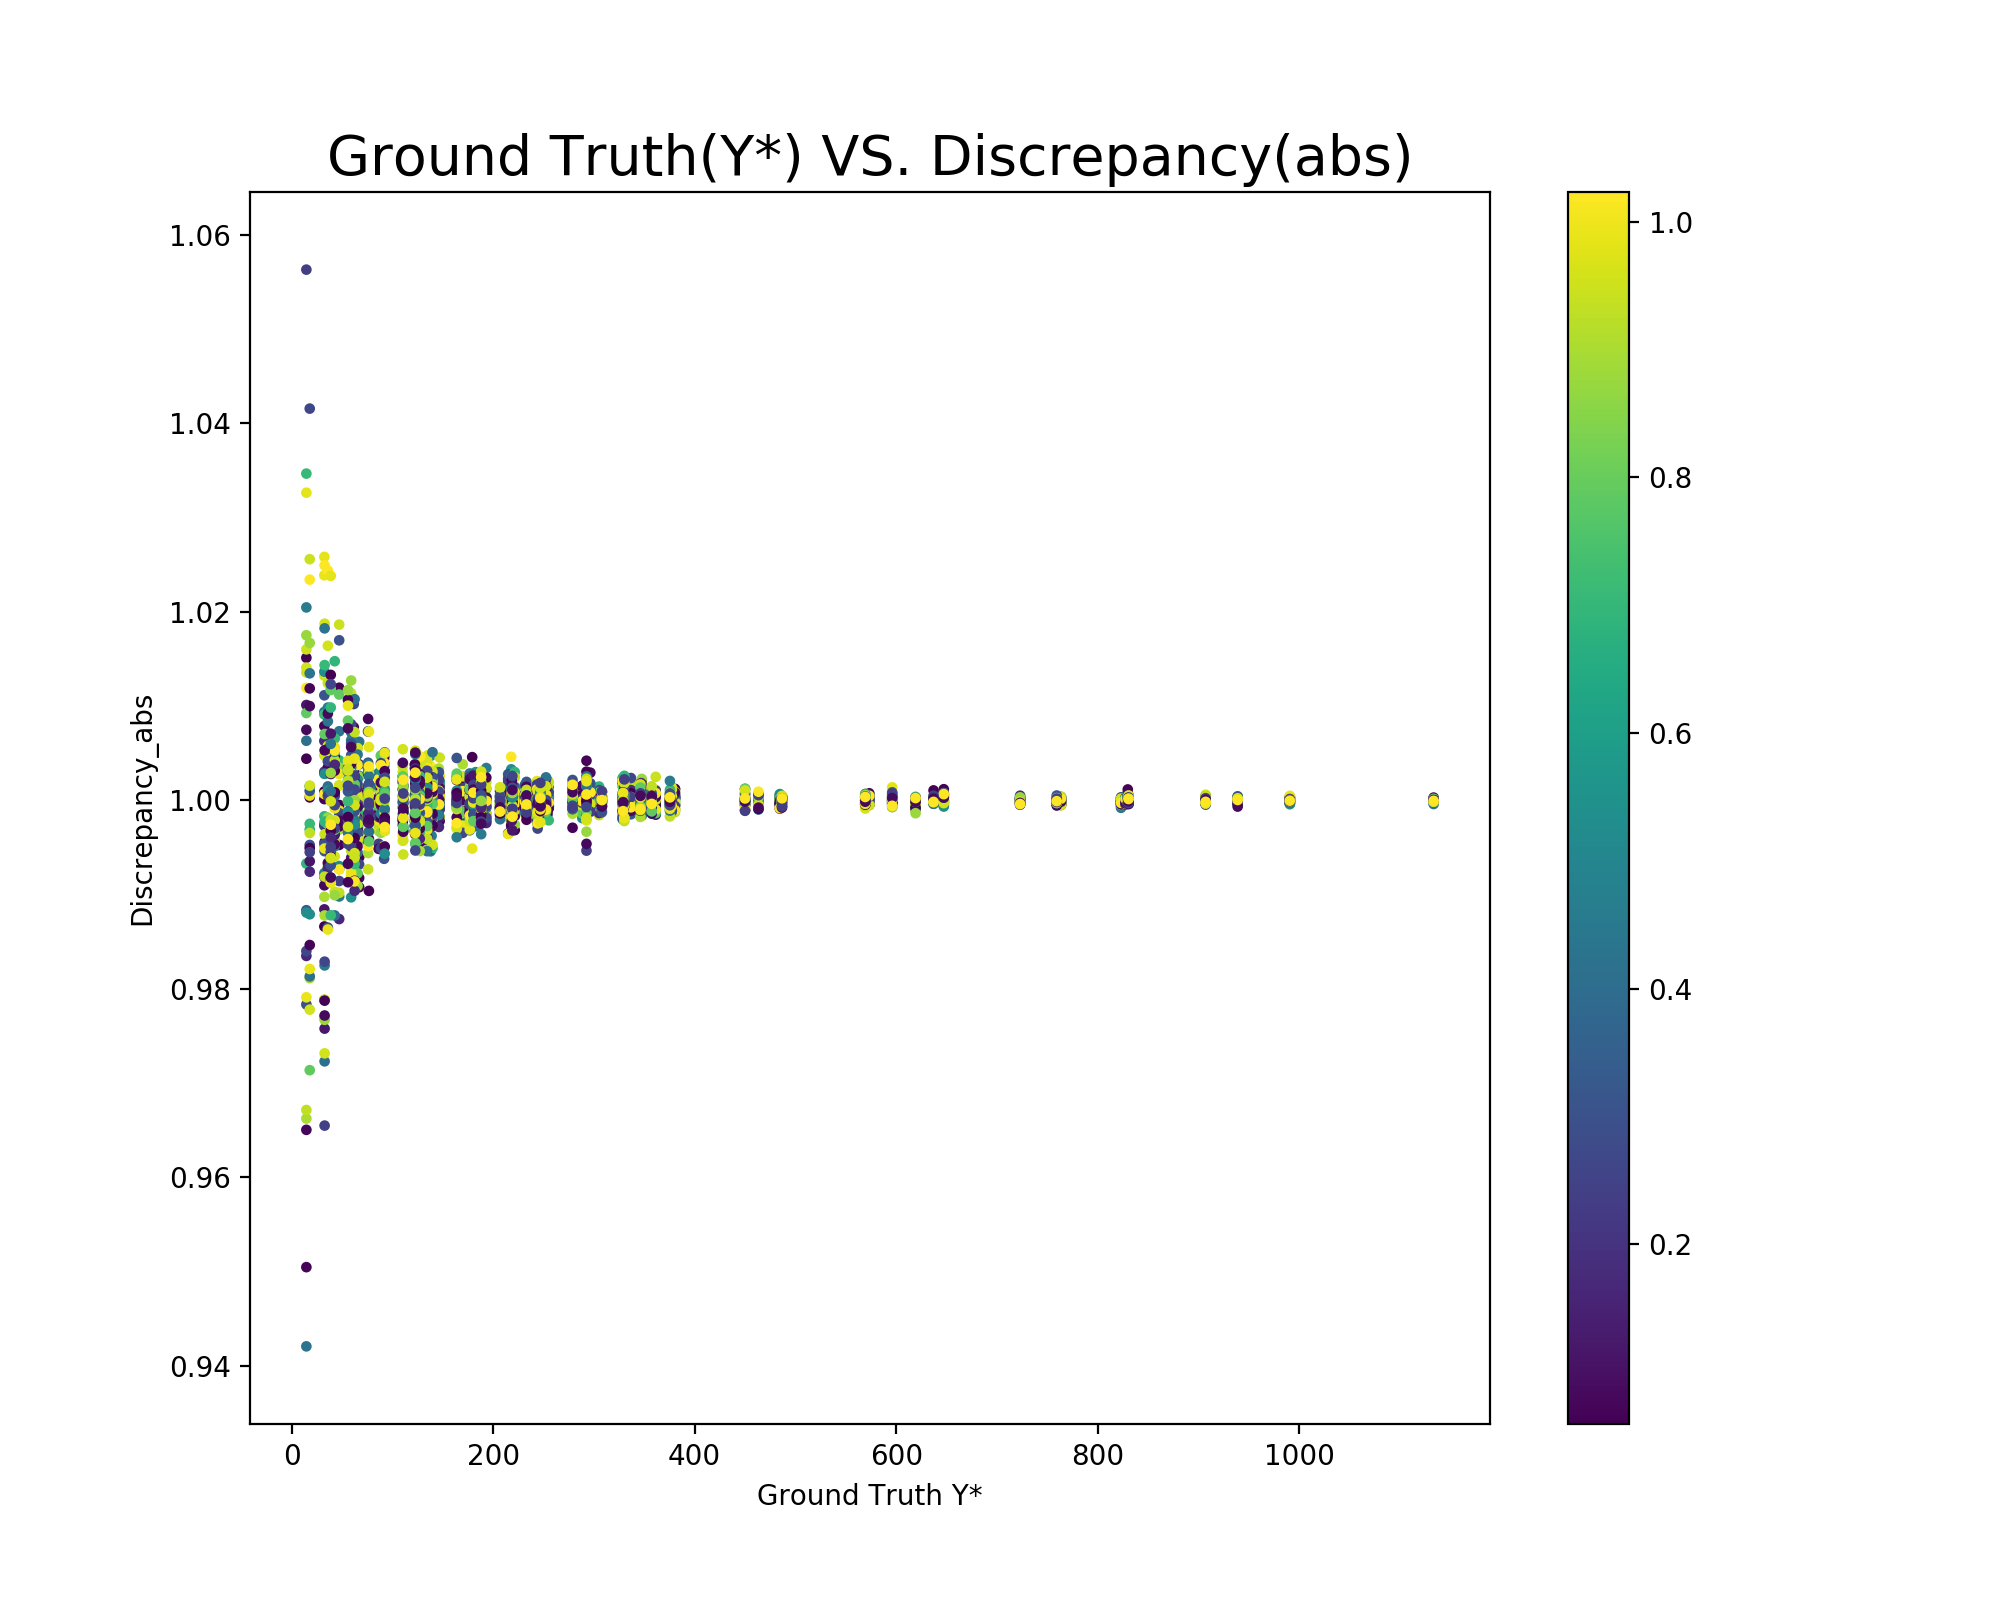

<IPython.core.display.Javascript object>


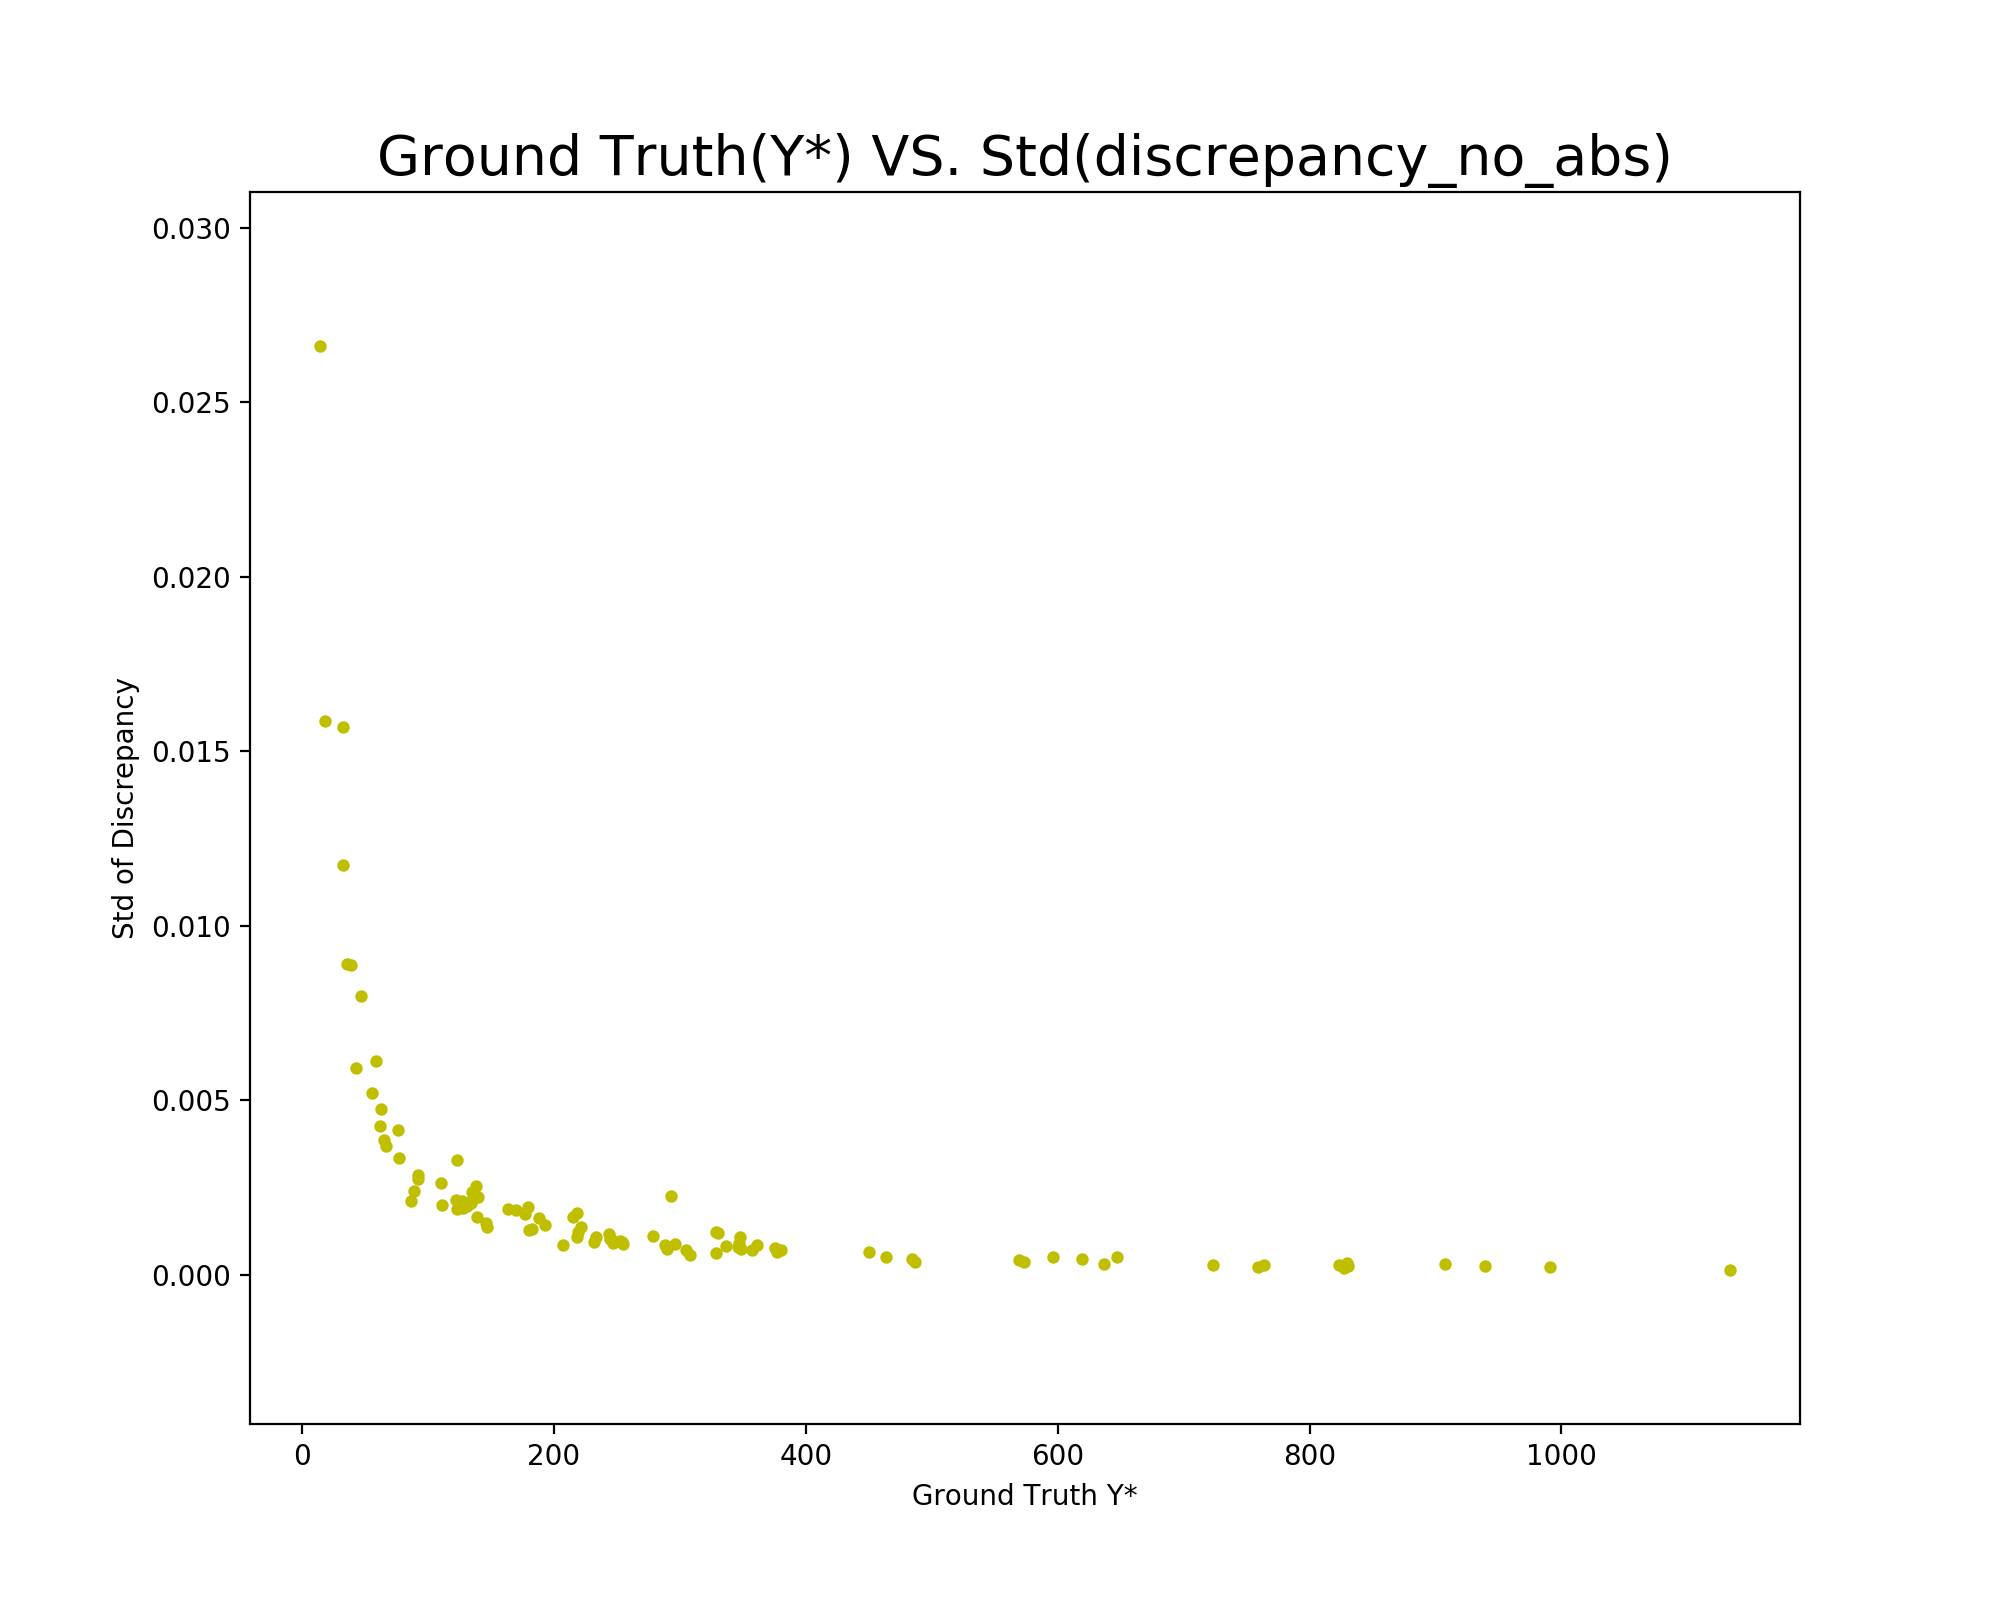

<IPython.core.display.Javascript object>


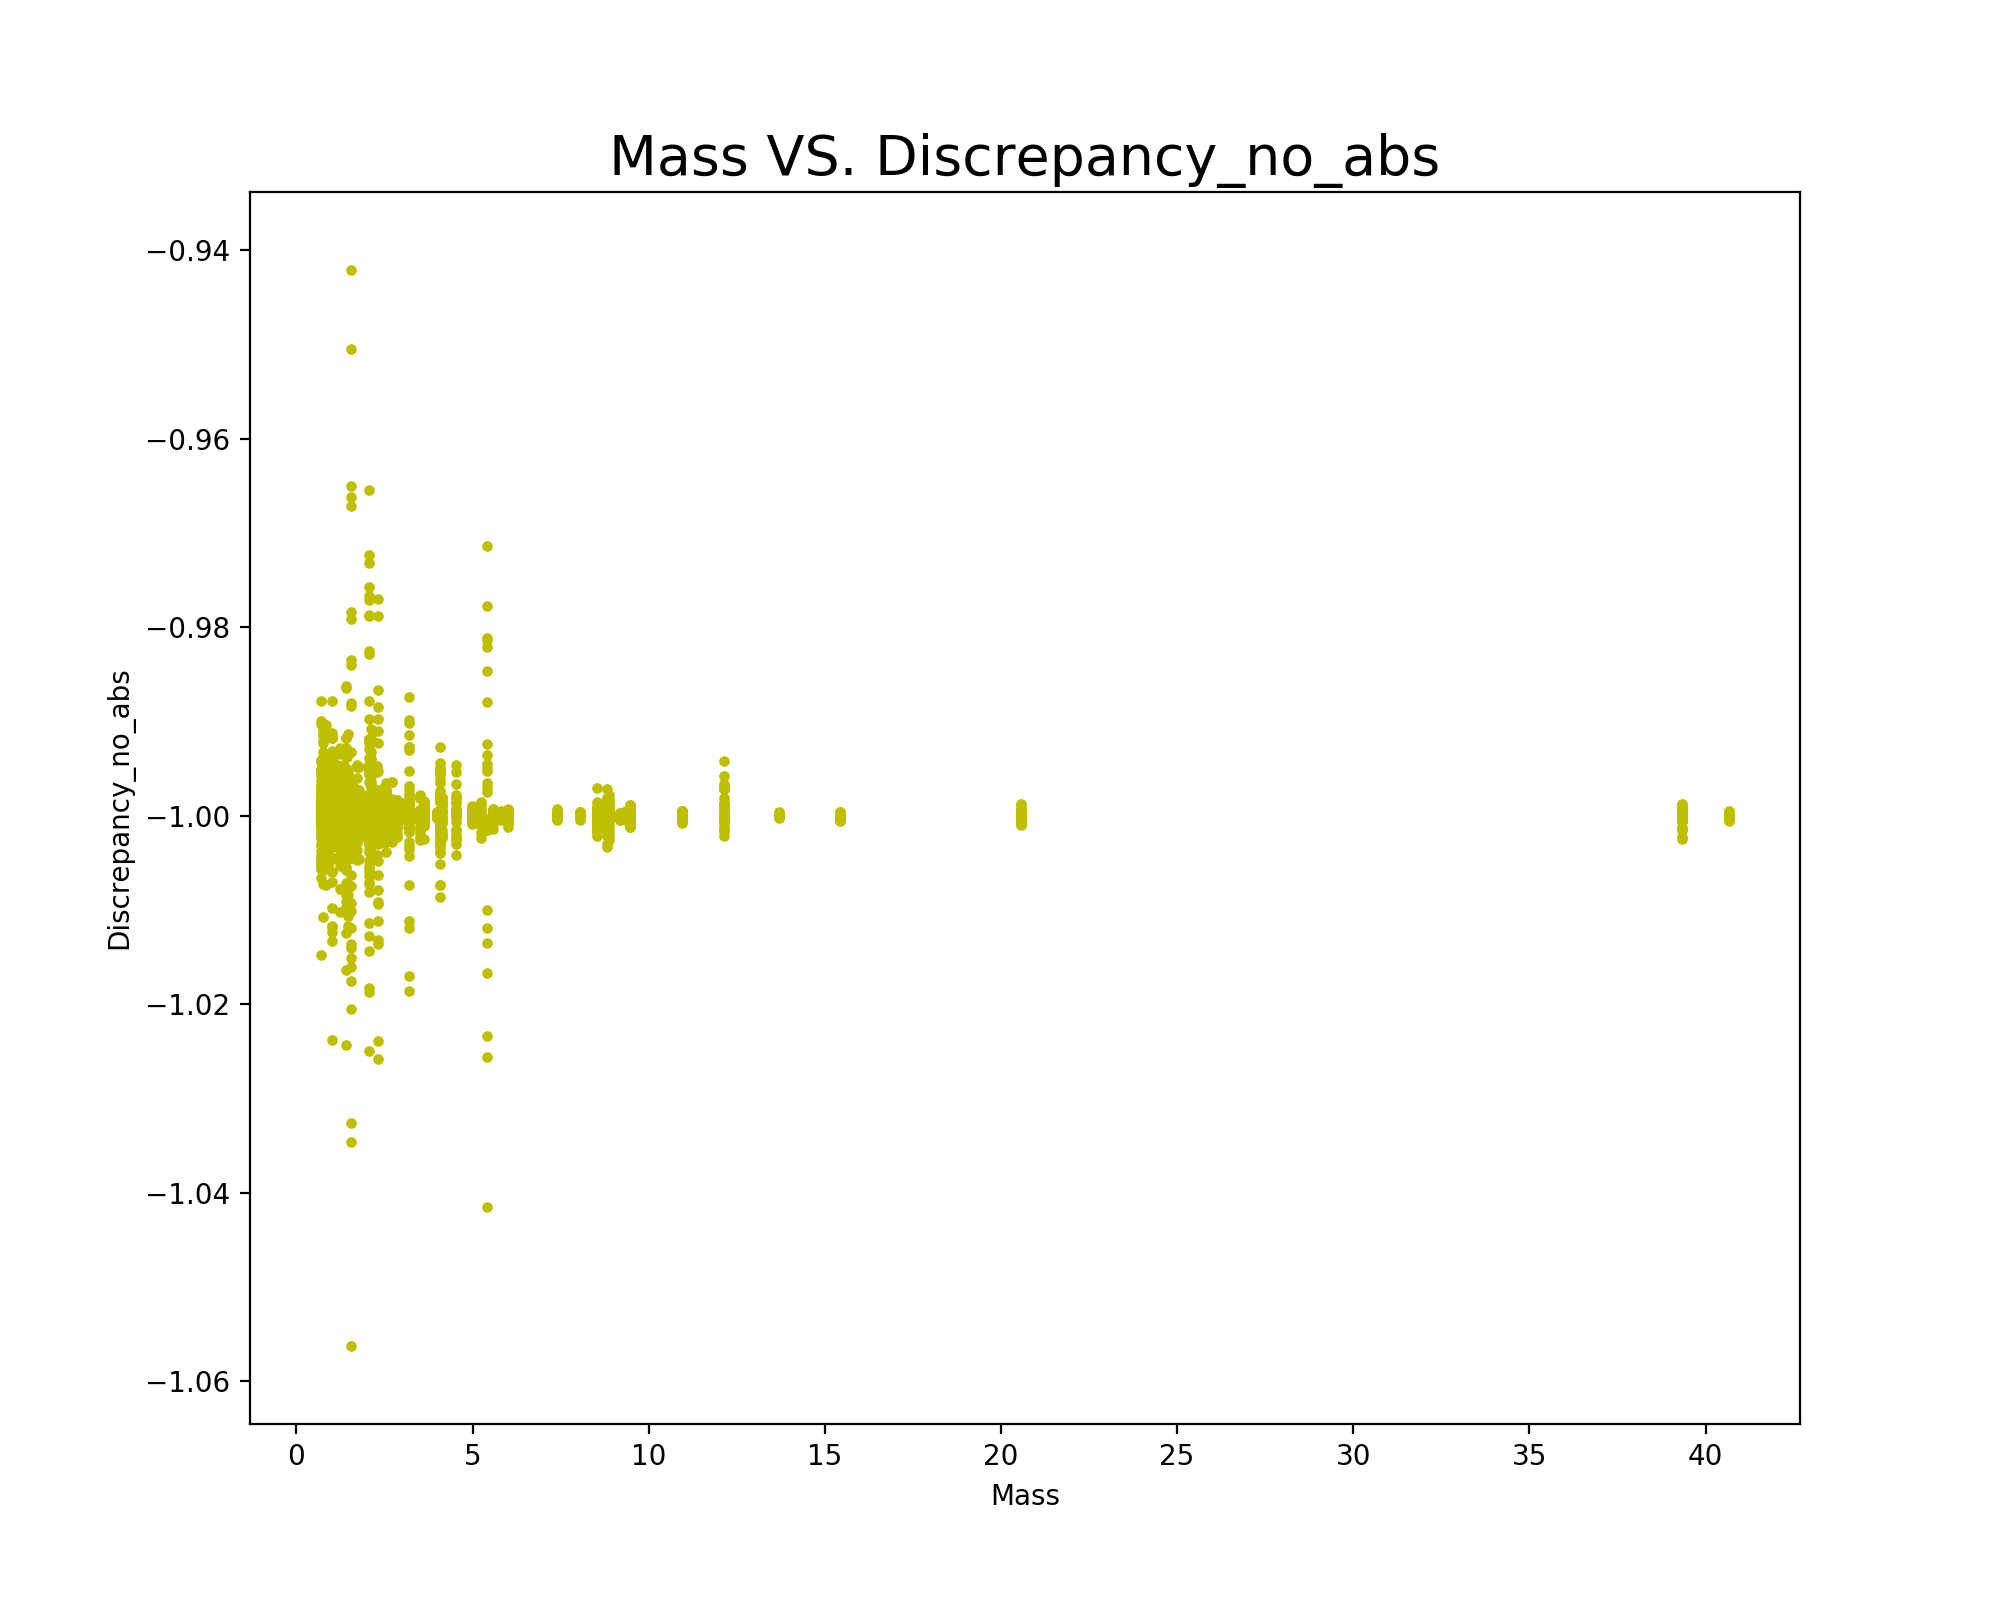

<IPython.core.display.Javascript object>


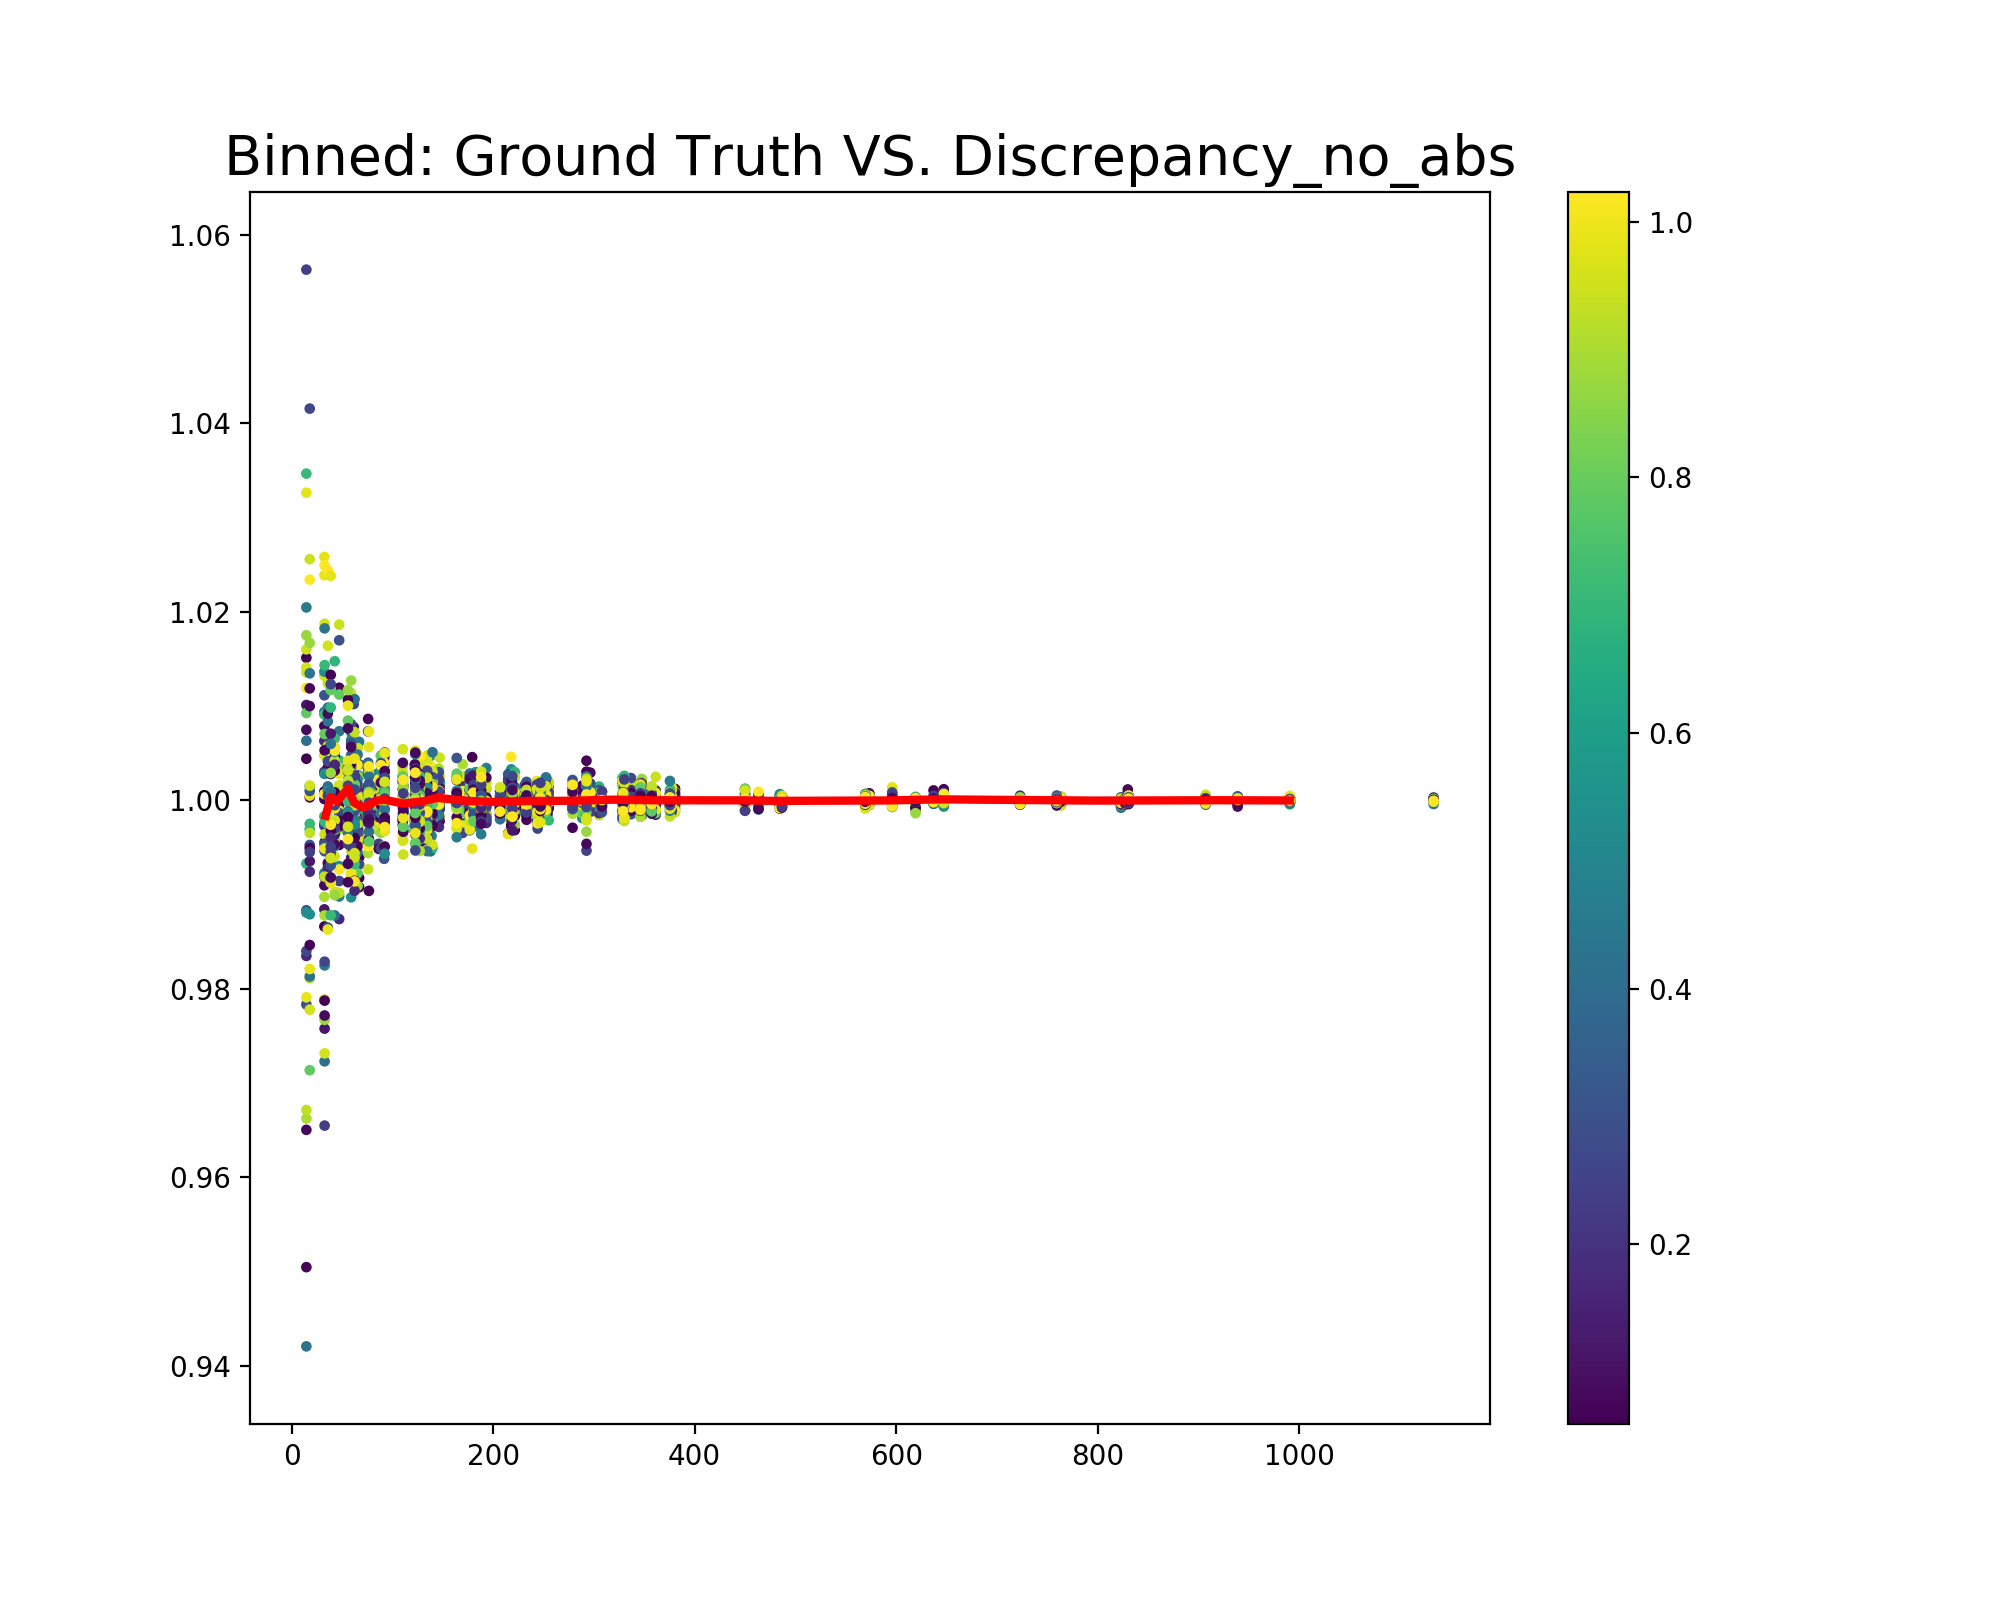

Predicting costs  119.013592004776  second.
Plotting costs  1.364975929260254  second.


In [21]:
import argparse
import torch
from torch.utils.data import DataLoader
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import load_data
import numpy as np
from sklearn.model_selection import train_test_split
import model
import datetime
import os
import json
from pprint import pprint
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import time
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

#model_config_dir = '/Users/GuoZhiqi/Downloads/conv_0.00001_11-config.json'
#net_config_dir = '/Users/GuoZhiqi/Downloads/conv_0.00001_11-best.net'
#test_dataset_dir = 


'''
Read model and make prediction
'''

time1 = time.time()
model_config = json.load(open('/Users/GuoZhiqi/Downloads/conv_0.00005_11-config.json'))
net = model.AllConvNet(model_config['filter_size'], model_config['n_conv'], image_size=model_config['image_size'])
net.load_state_dict(torch.load('/Users/GuoZhiqi/Downloads/conv_0.00005_11-best.net',map_location =lambda storage, loc:storage))

all_dataset = load_data.GalaxyImagesDataset(dataset_path='/Users/GuoZhiqi/Downloads/test.hdf5',
                                            ground_truth_path='/Users/GuoZhiqi/Downloads/ground_truth_new.csv',
                                            part_type='star')

train_loader = DataLoader(dataset=all_dataset, batch_size=64)
n_train_batch = len(train_loader)

from tqdm import tqdm

all_preds = np.array([])
all_labels = np.array([])
masses = np.array([])
discrepancy = []
net.eval()
for batch_idx, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
    
    x_batch = Variable(x_batch).float()
    all_weight = x_batch.data.numpy()[:,0] 
    mass = np.array([np.sum(matrix) for matrix in all_weight])
    y_batch = Variable(y_batch).float()
    preds = net(x_batch)
    masses = np.concatenate((masses,mass),axis=0)
    all_preds = np.concatenate((all_preds,preds.data.numpy()),axis=0)
    all_labels = np.concatenate((all_labels,y_batch.data.numpy()),axis=0)


'''
Get angles for test set
'''
df = h5py.File('/Users/GuoZhiqi/Downloads/test.hdf5') 
galaxy_list = [key for key in df.keys()]
all_angles = np.empty((27,3)) 
for galaxy in galaxy_list:
	all_angles = np.concatenate((all_angles,df[galaxy]['images']['angles']['angles_lst']))
all_angles = all_angles[27:]

time2 = time.time()



def Ground_truth_Prediction():
	'''
	Y* VS Y^
	'''
	fig, ax = plt.subplots(figsize=(10,8))
	plt.scatter(all_labels,all_preds,s=8,c=all_angles[:,1],cmap='viridis')
	plt.title('Ground Truth(Y*) VS. Prediction(Y^)',size=20)
	plt.xlabel("Ground Truth Y*")
	plt.ylabel("Prediction")

	cb = plt.colorbar()
	cb.set_ticklabels(all_angles[:,1])




def Ground_truth_Bias():
	'''
	Y* VS Y^ - Y*
	'''
	bias = [(p - y) for p,y in zip(all_preds,all_labels)]
	fig, ax = plt.subplots(figsize=(10,8))
	plt.scatter(all_labels,bias,s=8,c=all_angles[:,1],cmap='viridis')
	plt.title('Ground Truth(Y*) VS. Bias',size=20)
	plt.xlabel("Ground Truth Y*")
	plt.ylabel("Bias")

	cb = plt.colorbar() 
	cb.set_ticklabels(all_angles[:,1]) 


def Ground_truth_Disc_no_abs():
	'''
	Without no absolute value 
	Y* VS (Y^ - Y*)/Y*
	'''
	discrepancy_no_abs = [((p - y)/y) for p,y in zip(all_preds,all_labels)]
	fig, ax = plt.subplots(figsize=(10,8))
	plt.scatter(all_labels,discrepancy_no_abs,s=8,c=all_angles[:,1],cmap='viridis')
	plt.title('Ground Truth(Y*) VS. Discrepancy(no_abs)',size=20)
	plt.xlabel("Ground Truth Y*")
	plt.ylabel("Discrepancy_no_abs")
	cb = plt.colorbar() 
	cb.set_ticklabels(all_angles[:,1])


def Ground_truth_Disc():
	'''
	With absolute value
	Y* VS |Y^ - Y*|/Y*
	'''
	discrepancy = [np.abs((p - y)/y) for p,y in zip(all_preds,all_labels)]
	fig, ax = plt.subplots(figsize=(10,8))
	plt.scatter(all_labels,discrepancy,s=8,c=all_angles[:,1],cmap='viridis')
	plt.title('Ground Truth(Y*) VS. Discrepancy(abs)',size=20)
	plt.xlabel("Ground Truth Y*")
	plt.ylabel("Discrepancy_abs")
	cb = plt.colorbar() 
	cb.set_ticklabels(all_angles[:,1])

def construction_df():
	galaxy_df = all_dataset.map_df

	discrepancy = [np.abs((p - y)/y) for p,y in zip(all_preds,all_labels)]
	discrepancy_no_abs = [((p - y)/y) for p,y in zip(all_preds,all_labels)]

	galaxy_df['discrepancy'] = discrepancy
	galaxy_df['discrepancy_no_abs'] = discrepancy_no_abs
	galaxy_df['ground_truth'] = all_labels
	galaxy_df['mass'] = masses
	galaxy_df['angles_theta'] = all_angles[:,1]

	discre_ground_truth = galaxy_df.groupby('galaxy_name')[['discrepancy_no_abs','ground_truth']].mean()
	discre_ground_truth['std'] = galaxy_df.groupby('galaxy_name')['discrepancy_no_abs'].std()

	return galaxy_df, discre_ground_truth

def Ground_truth_Std():
	'''
	Y* VS Std(discrepancy_no_abs)
	'''

	
	fig, ax = plt.subplots(figsize=(10,8))
	_, discre_ground_truth = construction_df()
	plt.scatter(discre_ground_truth['ground_truth'],discre_ground_truth['std'],s=12,c='y')
	plt.title('Ground Truth(Y*) VS. Std(discrepancy_no_abs)',size=20)
	plt.xlabel("Ground Truth Y*")
	plt.ylabel("Std of Discrepancy")


def Mass_Disc_no_abs():
	'''
	Mass VS Discrepancy_no_abs
	'''
	galaxy_df, _ = construction_df()
	fig, ax = plt.subplots(figsize=(10,8))
	plt.scatter(galaxy_df['mass'],galaxy_df['discrepancy_no_abs'],s=8,c='y')
	plt.title('Mass VS. Discrepancy_no_abs',size=20)
	plt.xlabel("Mass")
	plt.ylabel("Discrepancy_no_abs")


def Binned_Ground_truth_Disc_no_abs():
	galaxy_df, _ = construction_df()

	fig, ax = plt.subplots(figsize=(10,8))
	dff = pd.DataFrame({'X' : galaxy_df['ground_truth'], 'Y' : galaxy_df['discrepancy']})  #we build a dataframe from the data
	total_bins = 30
	bins = np.geomspace(galaxy_df['ground_truth'].min(), galaxy_df['ground_truth'].max(), total_bins)
	data_cut = pd.cut(dff.X,bins)         
	grp = dff.groupby(by = data_cut)     #we group the data by the cut
	ret = grp.aggregate(np.mean)         #we produce an aggregate representation (median) of each bin
	plt.scatter((galaxy_df['ground_truth']),galaxy_df['discrepancy'],s=8,c=all_angles[:,1],cmap='viridis')
	plt.plot(ret.X,ret.Y,'r-',linewidth=3)
	cb = plt.colorbar() 
	cb.set_ticklabels(all_angles[:,1])
	plt.title('Binned: Ground Truth VS. Discrepancy_no_abs',size=20)
	plt.show()



def All_Plotter():
	time3 = time.time()

	Ground_truth_Prediction()
	Ground_truth_Bias()
	Ground_truth_Disc_no_abs()
	Ground_truth_Disc()
	Ground_truth_Std()
	Mass_Disc_no_abs()
	Binned_Ground_truth_Disc_no_abs()

	time4 = time.time()
	print ('Predicting costs ', time2-time1, ' second.')
	print ('Plotting costs ', time4-time3, ' second.')


All_Plotter()






In [22]:
a,b = construction_df()

In [23]:
a

,galaxy_name,angle_idx,discrepancy,discrepancy_no_abs,ground_truth,mass,angles_theta
0,sub102710_s99_sg,0,0.966240,-0.966240,14.671248,1.555887,0.900954
1,sub102710_s99_sg,1,0.993286,-0.993286,14.671248,1.555887,0.691863
2,sub102710_s99_sg,2,1.015126,-1.015126,14.671248,1.555887,0.059332
3,sub102710_s99_sg,3,1.006322,-1.006322,14.671248,1.555887,0.408813
4,sub102710_s99_sg,4,1.010110,-1.010110,14.671248,1.555887,0.118123
5,sub102710_s99_sg,5,1.034664,-1.034664,14.671248,1.555887,0.709736
6,sub102710_s99_sg,6,1.032639,-1.032639,14.671248,1.555887,0.984073
7,sub102710_s99_sg,7,1.013565,-1.013565,14.671248,1.555887,0.956490
8,sub102710_s99_sg,8,0.988339,-0.988339,14.671248,1.555887,0.308919
9,sub102710_s99_sg,9,0.965040,-0.965040,14.671248,1.555887,0.071381


In [24]:
all_labels

array([  14.67124844,   14.67124844,   14.67124844, ...,  188.15267944,
        188.15267944,  188.15267944])

In [25]:
all_preds

array([ 0.49530596,  0.09850425, -0.22192176, ..., -0.31468874,
        0.46666086, -0.46306086])

In [26]:
np.max(all_preds)

1.5622589588165283

In [27]:
np.min(all_preds)

-1.229790210723877